# 2. Slug Test - Falling Head

### Import packages

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import timflow.transient as tft

plt.rcParams["figure.figsize"] = [5, 3]

### Introduction and Conceptual Model

This slug test, taken from the AQTESOLV examples (Duffield, 2007), was reported in Batu (1998). 

A well partially penetrates a sandy unconfined aquifer that has a saturated depth of 32.57 ft. The top of the screen is located 0.47 ft below the water table and has 13.8 ft in length. The well and casing radii are 5 and 2 inches, respectively. The slug displacement is 1.48 ft. Head change has been recorded at the slug well.

<img src="./figs/Falling_head.png" style="width:400pt">

### Load data

In [11]:
data = np.loadtxt("data/falling_head.txt", skiprows=2)
to = data[:, 0] / 60 / 60 / 24  # convert time from seconds to days
ho = (10 - data[:, 1]) * 0.3048  # convert drawdown from ft to meters

### Parameters and model

In [14]:
rw = 5 * 0.0254 # well radius in m (5 inch = 0.127 m)
rc = 2 * 0.0254  # well casing radius in m (2 inch = 0.0508 m) 
L = 13.8 * 0.3048 # screen length in m (13.8 ft = 4.2 m) 
b = -32.57 * 0.3048 # aquifer thickness in m (-32.57 ft = -9.92 m) 
zt = -0.47 * 0.3048 # depth to top of the screen in m (-0.47 ft = -0.14 m) 
H0 = 1.48 * 0.3048 # initial displacement in the well in m (1.48 ft = 0.4511 m)
zb = zt - L  # bottom of the screen in m

convert measured displacement into volume

In [17]:
Q = np.pi * rc**2 * H0
print(f"slug: {Q:.5f} m^3")

slug: 0.00366 m^3


We will create a multi-layer model. For this, we divide the second and third layers into 0.5 m thick layers. 

In [20]:
# The thickness of each layer is set to be 0.5 m
z0 = np.arange(zt, zb, -0.5)
z1 = np.arange(zb, b, -0.5)
zlay = np.append(z0, z1)
zlay = np.append(zlay, b)
zlay = np.insert(zlay, 0, 0)
nlay = len(zlay) - 1  # number of layers
Saq = 1e-4 * np.ones(nlay)
Saq[0] = 0.1

In [22]:
ml = tft.Model3D(
    kaq=10, z=zlay, Saq=Saq, kzoverkh=1, tmin=1e-5, tmax=0.01, phreatictop=True
)
w = tft.Well(
    ml,
    xw=0,
    yw=0,
    rw=rw,
    tsandQ=[(0, -Q)],
    layers=[1, 2, 3, 4, 5, 6, 7, 8],
    rc=rc,
    wbstype="slug",
)
ml.solve()

self.neq  8
solution complete


### Estimate aquifer parameters

In [24]:
cal = tft.Calibrate(ml)
cal.set_parameter(name="kaq", layers= list(range(nlay)), initial=10, pmin=0) 
cal.set_parameter(name="Saq", layers= list(range(nlay)), initial=1e-4, pmin=0) 
cal.seriesinwell(name="obs", element=w, t=to, h=ho)
cal.fit(report=True)

...................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 32
    # data points      = 27
    # variables        = 2
    chi-square         = 0.00108532
    reduced chi-square = 4.3413e-05
    Akaike info crit   = -269.286376
    Bayesian info crit = -266.694703
[[Variables]]
    kaq_0_21:  0.49527891 +/- 0.02256667 (4.56%) (init = 10)
    Saq_0_21:  4.0641e-04 +/- 1.0404e-04 (25.60%) (init = 0.0001)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq_0_21, Saq_0_21) = -0.9593


In [26]:
display(cal.parameters)
print("RMSE:", cal.rmse())

,layers,optimal,std,perc_std,pmin,pmax,initial,inhoms,parray
kaq_0_21,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.495279,0.022567,4.556355,0.0,inf,10.0000,None,"[[0.49527890522676343, 0.49527890522676343, 0...."
Saq_0_21,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.000406,0.000104,25.601228,0.0,inf,0.0001,None,"[[0.00040640566742622397, 0.000406405667426223..."


RMSE: 0.0063401121553331085


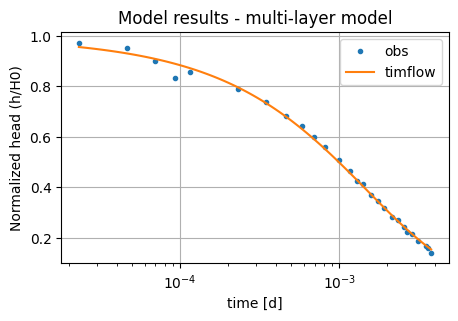

In [36]:
tm = np.logspace(np.log10(to[0]), np.log10(to[-1]), 100)
hm = w.headinside(tm)
plt.semilogx(to, ho / H0, ".", label="obs")
plt.semilogx(tm, hm[0] / H0, label="timflow")
plt.xlabel("time [d]")
plt.ylabel("Normalized head (h/H0)")
plt.title("Model results - multi-layer model")
plt.legend()
plt.grid()

### Comparison of results
Here, the `timflow` performance in analysing slug tests is checked. The solution in `timflow` is compared with the KGS analytical model (Hyder et al. 1994) implemented in AQTESOLV (Duffield, 2007). AQTESOLV parameters are quite different from the set parameters in `timflow`. Furthermore, AQTESOLV also has a better RMSE performance.

In [31]:
t = pd.DataFrame(
    columns=["k [m/d]", "Ss [1/m]", "RMSE [m]"],
    index=["timflow", "AQTESOLV"],
)

t.loc["timflow"] = np.append(cal.parameters["optimal"].values, cal.rmse())
t.loc["AQTESOLV"] = [2.616, 7.894e-5, 0.001197]

t_formatted = t.style.format(
    {"k [m/d]": "{:.2f}", "Ss [1/m]": "{:.2e}",  "RMSE [m]": "{:.3f}"}
)
t_formatted

,k [m/d],Ss [1/m],RMSE [m]
timflow,0.50,4.06e-04,0.006
AQTESOLV,2.62,7.89e-05,0.001


## References

* Batu, V. (1998), Aquifer hydraulics: a comprehensive guide to hydrogeologic data analysis, John Wiley & Sons
* Duffield, G.M. (2007), AQTESOLV for Windows Version 4.5 User's Guide, HydroSOLVE, Inc., Reston, VA.
* Hyder, Z., Butler Jr, J.J., McElwee, C.D. and Liu, W. (1994), Slug tests in partially penetrating wells, Water Resources Research 30, 2945–2957.